# Regularization: L1 and L2 (Detailed Notes)

This cell explains L1 (Lasso) and L2 (Ridge / weight decay) regularization with mathematics and intuition.

## Setup

Given a dataset with loss (data loss) $\mathcal{L}_{data}(w)$ for model parameters $w \in \mathbb{R}^d$, regularization adds a penalty:

$$\mathcal{L}_{total}(w) = \mathcal{L}_{data}(w) + \lambda \; R(w)$$

where $\lambda \ge 0$ controls penalty strength and $R(w)$ is the regularizer.

## L2 regularization (Ridge, weight decay)

- Definition: $R_{2}(w) = \tfrac{1}{2}\|w\|_2^2 = \tfrac{1}{2}\sum_{i=1}^d w_i^2$.
- Total loss: $\mathcal{L}_{tot}(w)=\mathcal{L}_{data}(w)+\lambda\tfrac{1}{2}\|w\|_2^2$.
- Gradient: $\nabla_w\mathcal{L}_{tot} = \nabla_w\mathcal{L}_{data}(w) + \lambda w$.
- Effect: adds a linear term in gradient that "pulls" weights toward zero, shrinking them but not forcing exact zeros.
- Equivalence to weight decay (discrete updates): for SGD step $w\leftarrow w-\eta\nabla_w\mathcal{L}_{tot}$, the L2 part gives $w\leftarrow(1-\eta\lambda)w-\eta\nabla_w\mathcal{L}_{data}$; this multiplicative factor is called weight decay.
- Closed-form (OLS): for linear regression, ridge solution is $w=(X^TX+\lambda I)^{-1}X^Ty$ which stabilizes inversion when $X^TX$ is ill-conditioned.

## L1 regularization (Lasso)

- Definition: $R_{1}(w)=\|w\|_1=\sum_{i=1}^d|w_i|$.
- Total loss: $\mathcal{L}_{tot}(w)=\mathcal{L}_{data}(w)+\lambda\|w\|_1$.
- Subgradient: for $w_i\ne0$, $\partial_{w_i}\|w\|_1=\operatorname{sign}(w_i)$; at $w_i=0$ the subgradient is the interval $[-1,1]$.
- Effect: encourages sparsity — many weights become exactly zero, which performs feature selection.
- Proximal (soft-thresholding) operator: when using proximal methods,

$$\operatorname{prox}_{\alpha\|\cdot\|_1}(v)=\arg\min_w\tfrac{1}{2}\|w-v\|_2^2+\alpha\|w\|_1 = \mathrm{sign}(v)\max(|v|-\alpha,0).$$

This shows coordinates with $|v|\le\alpha$ are set to zero.

## Comparison and trade-offs

- L2: smooth penalty, convex, differentiable; reduces variance, keeps all features but smaller weights.
- L1: non-differentiable at 0, convex; yields sparse solutions and feature selection.
- Elastic Net: combine both: $R(w)=\alpha\|w\|_1+\tfrac{1-\alpha}{2}\|w\|_2^2$ to get benefits of both.

## In neural networks

- Regularization term is added to the loss and backpropagated via the extra gradient term; L2 is most common as weight decay.
- For L2 and small learning rate $\eta$, weight decay update approximates continuous-time ODE $\dot w=-\nabla_w\mathcal{L}_{data}-\lambda w$ (exponential decay).
- L1 is less common inside standard SGD because of subgradients, but can be implemented via proximal updates or by adding L1 penalty and using optimizers that support it.

## Practical notes

- Choose $\lambda$ via validation/cross-validation. Typical ranges depend on data scale; try log-spaced values.
- Normalize features before regularization; otherwise penalty interacts with feature scale.
- When using frameworks (Keras/PyTorch), L2 is often specified as kernel_regularizer or weight_decay parameter.

## Quick formulas summary

- L2 total loss: $\mathcal{L}_{data}+\lambda\tfrac{1}{2}\|w\|_2^2$; gradient addend $\lambda w$.
- L1 total loss: $\mathcal{L}_{data}+\lambda\|w\|_1$; subgradient addend $\lambda\operatorname{sign}(w)$.

References: ridge/lasso literature; proximal operator for L1 (soft-threshold).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
X, y = make_moons(100, noise=0.25, random_state=2)

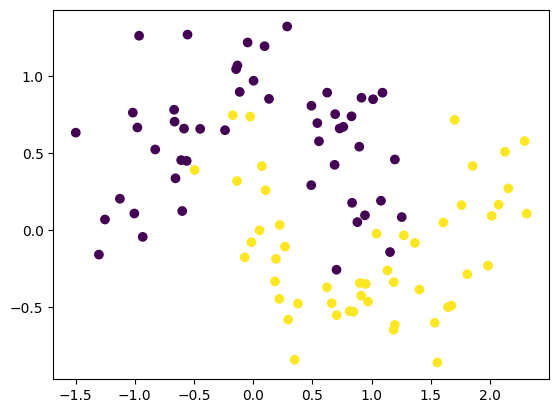

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [ ]:
model1 = Sequential()

model1.add(Dense(128, input_dim=2, activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))

model1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = Adam(learning_rate=0.01)
model1.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

history1 = model1.fit(X, y, epochs=2000, validation_split=0.2, verbose=0)

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


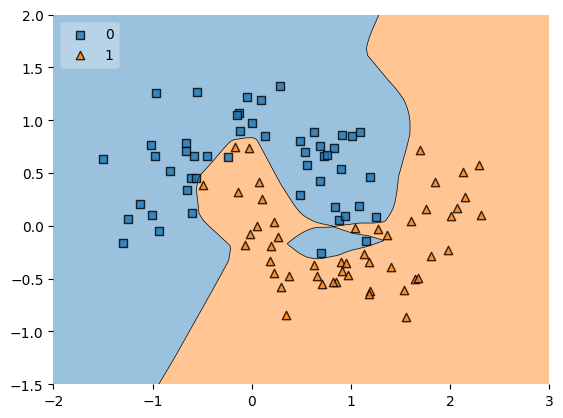

In [ ]:
plot_decision_regions(X, y.astype("int"), clf=model1, legend=2)
plt.xlim(-2, 3)
plt.ylim(-1.5, 2)
plt.show()

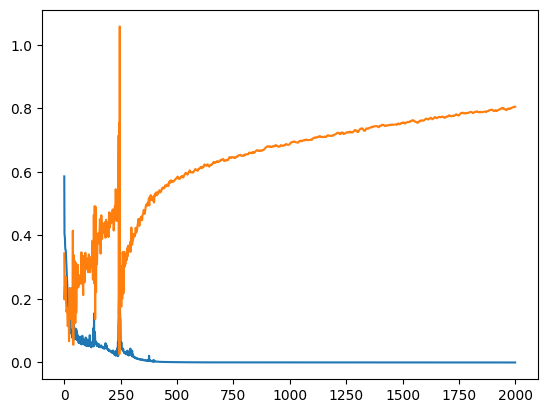

In [ ]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.show()

In [ ]:
model2 = Sequential()

model2.add(
    Dense(
        128,
        input_dim=2,
        activation="relu",
        kernel_regularizer=tensorflow.keras.regularizers.l1(0.001),
    )
)
model2.add(
    Dense(
        128,
        activation="relu",
        kernel_regularizer=tensorflow.keras.regularizers.l1(0.001),
    )
)
model2.add(Dense(1, activation="sigmoid"))

model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = Adam(learning_rate=0.01)
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

history2 = model2.fit(X, y, epochs=2000, validation_split=0.2, verbose=0)

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


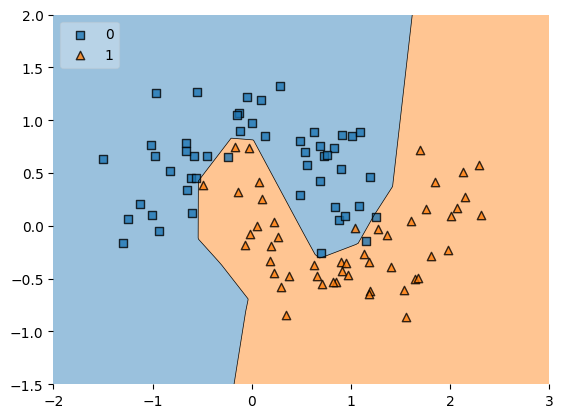

In [ ]:
plot_decision_regions(X, y.astype("int"), clf=model2, legend=2)
plt.xlim(-2, 3)
plt.ylim(-1.5, 2)
plt.show()

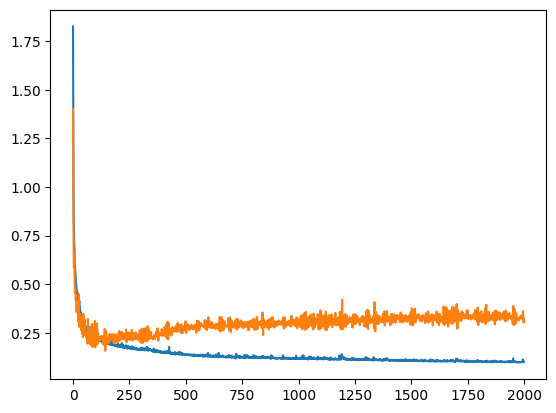

In [ ]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.show()

In [14]:
model1_weight_layer1 = model1.get_weights()[0].reshape(256)
model2_weight_layer1 = model2.get_weights()[0].reshape(256)

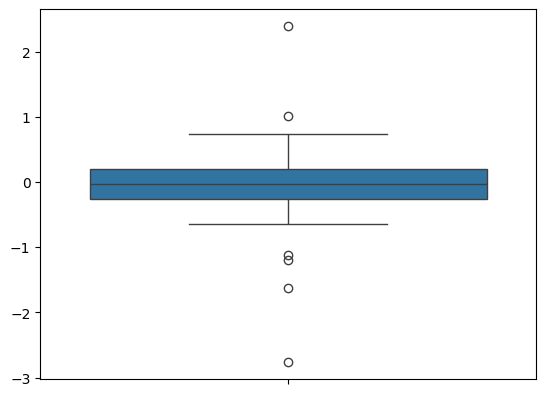

In [17]:
sns.boxplot(model1_weight_layer1)
plt.show()

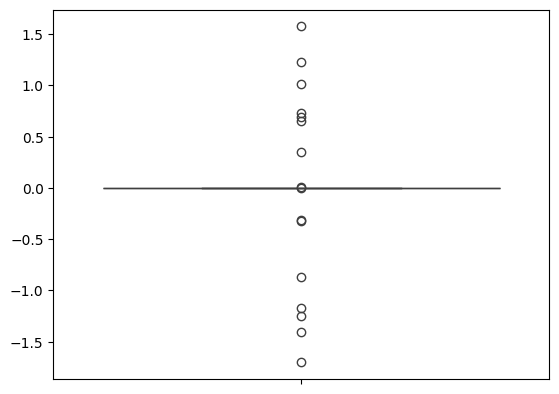

In [19]:
sns.boxplot(model2_weight_layer1)
plt.show()

In [20]:
model1_weight_layer1.min()

np.float32(-2.764341)

In [21]:
model2_weight_layer1.min()

np.float32(-1.7015237)

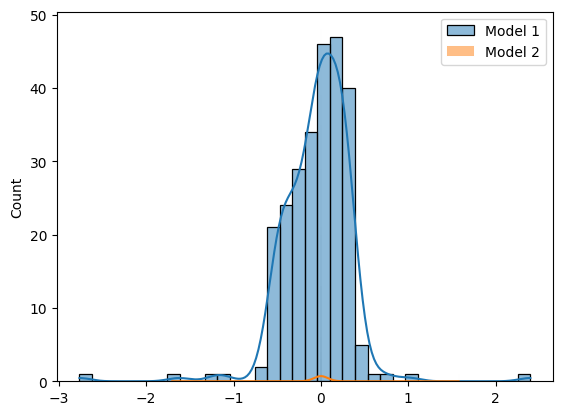

In [ ]:
sns.histplot(model1_weight_layer1, kde=True, label="Model 1")
sns.histplot(model2_weight_layer1, kde=True, label="Model 2")
plt.legend()
plt.show()

In [29]:
model1.get_weights()[0].reshape(256)

array([-5.55152372e-02, -5.07199705e-01, -3.09678435e-01,  2.96305627e-01,
       -4.28533822e-01,  3.95217896e-01, -4.71381754e-01,  2.59743124e-01,
       -4.59244192e-01, -3.63606036e-01, -4.10582930e-01, -2.79377364e-02,
        2.47347206e-01, -4.82659817e-01, -5.67902960e-02,  2.65165210e-01,
        1.30523339e-01, -2.59637475e-01, -2.31945571e-02,  1.42282084e-01,
       -2.82411009e-01, -5.14360487e-01, -4.22685832e-01, -5.88592708e-01,
        2.27205709e-01,  2.41096377e-01,  2.40009740e-01, -7.31923208e-02,
       -3.86492312e-01, -4.23608124e-01,  2.80199319e-01, -6.39374495e-01,
        4.55996878e-02,  1.15866750e-01, -2.35947445e-02, -3.94325703e-01,
        1.62499443e-01, -5.43609500e-01,  2.09008381e-01,  2.86991626e-01,
       -4.01319146e-01, -6.39336169e-01, -4.21660453e-01,  2.50830799e-01,
        5.23697138e-02, -5.38703740e-01,  1.37419924e-02,  2.90032923e-01,
        3.08707416e-01, -4.80152369e-01,  1.89758003e-01,  1.37007087e-01,
       -9.80068669e-02,  